In [2]:

# ID                Name
# 6531501217      Khant Zay Lin
# 6531501218      Khun Min Khant Zaw
# 6531501204      Aung Phyo Linn
# 6531501231      Taryar Thaw Zin



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import joblib
import os

In [4]:
# =============================================================================
# Load the dataset
# =============================================================================
try:
    data = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'WA_Fn-UseC_-HR-Employee-Attrition.csv' not found.")
    exit()

# Drop constant columns
data = data.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis=1)

# =============================================================================
# Data Preprocessing
# =============================================================================
le_attrition = LabelEncoder()
data['Attrition'] = le_attrition.fit_transform(data['Attrition'])

# Identify categorical columns for encoding
categorical_cols = data.select_dtypes(include='object').columns
categorical_mappings = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    categorical_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Drop multicollinear features
data = data.drop(['MonthlyRate', 'HourlyRate'], axis=1)

# =============================================================================
# Define Features and Target
# =============================================================================
X = data.drop('Attrition', axis=1)
y = data['Attrition']

# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Dataset loaded successfully.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_


Model Evaluation:
Accuracy: 0.9028
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       250
           1       0.92      0.88      0.90       244

    accuracy                           0.90       494
   macro avg       0.90      0.90      0.90       494
weighted avg       0.90      0.90      0.90       494



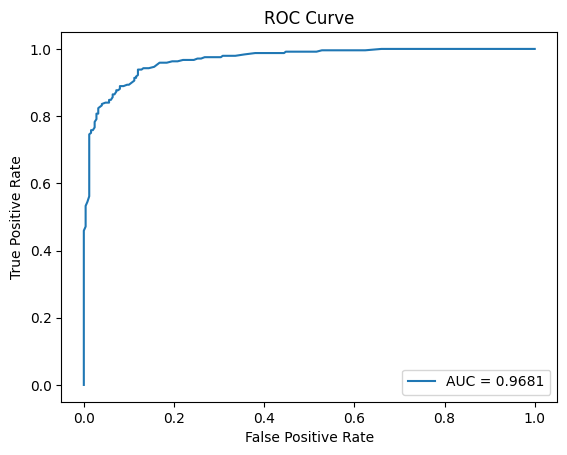


Model, Scaler, and Mappings saved successfully.


''

In [5]:
# =============================================================================
# Model Training with Hyperparameter Tuning
# =============================================================================
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

model = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

# =============================================================================
# Model Evaluation
# =============================================================================
y_pred = model.predict(X_test_scaled)
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# ROC Curve
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_prob):.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Save the model and scaler
joblib.dump(model, 'employee_attrition_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(categorical_mappings, 'categorical_mappings.pkl')
print("\nModel, Scaler, and Mappings saved successfully.")
""